**кластеризатор КНП**


Евгений Борисов esborisov@sevsu.ru


---

In [4]:
import numpy as np
from numpy import random as rng
import numpy.ma as ma

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

np.set_printoptions(precision=2)

In [24]:
# from sklearn.datasets import make_blobs

# X,_ = make_blobs(n_samples=256,centers=5,cluster_std=rng.uniform(size=5)+.7 )
# display( X.shape )

# fig, ax = plt.subplots(figsize=(6,5))
# ax.scatter( x=X[:,0], y=X[:,1], s=2, alpha=0.5 )
# ax.grid()
# plt.show()

(256, 2)

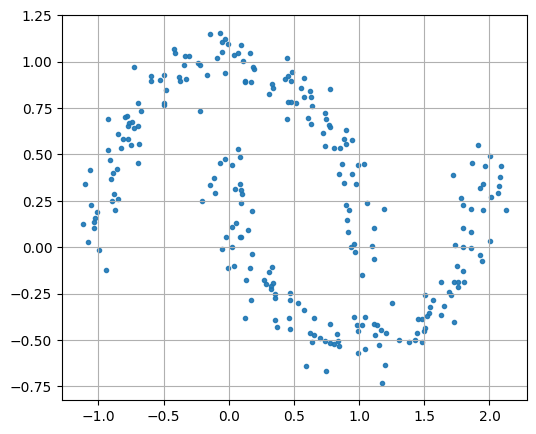

In [25]:
from sklearn.datasets import make_moons

X, _ = make_moons(n_samples=256, noise=.09)
display( X.shape )

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter( x=X[:,0], y=X[:,1], marker='.', alpha=.9 )
ax.grid()
plt.show()

---

In [26]:
from sklearn.metrics.pairwise import euclidean_distances as metric

In [27]:
class KNPClustering:
    
    def __init__(self,metric=metric):
        self._metric = metric
        
    def fit(self,X): return self
    
    def predict(self,X,n_split=1): 
        assert n_split>0
        D,edges = self._build_graph(X)
        edges = self._split_graph(D,edges,n_split)
        labels = self._edges_to_labels(edges)
        return labels, edges
        
    def _build_graph(self,X):        
        D,edges = self._init_graph(X)
        for _ in tqdm(range(len(X)-2)):
            edges = self._add_node(D,edges)
        return D,edges
        
    def _init_graph(self,X):
        D = metric(X) # матрица расстояний
        # маскируем верхнюю часть матрицы расстояний, включая главную диагональ
        D_ = ma.masked_array( D, mask=np.triu(np.ones(D.shape,dtype=np.uint8)) ) 
        p_idx = ma.where( D_ == D_.min() ) # ищем две наиболее близкие точки
        return D, [ [ p_idx[0][0], p_idx[1][0] ], ] # соединяем их ребром    
        
    @staticmethod
    def _add_node(D,edges):
        p_used = sorted(set(sum(edges,[]))) # список связанных точек
        p_free = list(set(range(D.shape[0])).difference(p_used)) # список несвязанных точек
        # маскируем главную диагональ ...
        mask = np.eye(D.shape[0],dtype=np.uint8)
        # ... и пары из уже связанных или ещё несвязанных точек
        mask = mask[p_used,:][:,p_free]
        # ищем ближайшую к графу несвязанную точку 
        D_ = ma.masked_array( D[p_used,:][:,p_free], mask=mask )
        p_idx = ma.where( D_ == D_.min() )
        # добавляем новое ребро к графу
        return edges + [ [ p_used[p_idx[0][0]], p_free[p_idx[1][0]] ] ]

    @staticmethod
    def _split_graph(D,edges,n_split=1):
        edge_max_idx = np.argsort( [ D[*e] for e in edges ] )[-n_split:]
        return [ edges[n] for n in range(len(edges)) if not (n in edge_max_idx) ]

    @classmethod
    def _edges_to_labels(cls,edges):
        return []

In [32]:
model = KNPClustering().fit(X)
labels,edges = model.predict(X,n_split=1)

  0%|          | 0/254 [00:00<?, ?it/s]

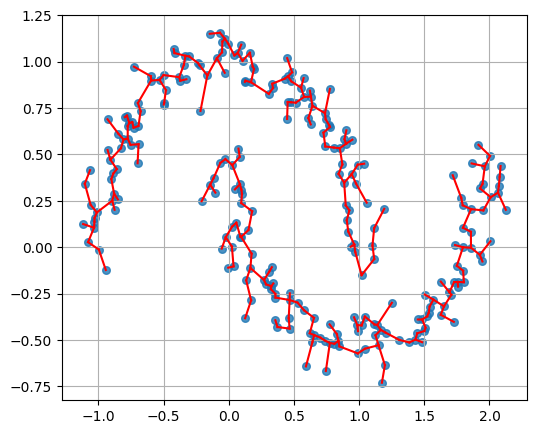

In [33]:
# рисуем полный граф
edge_points = [ [ [ X[n1,0],X[n2,0] ], [ X[n1,1],X[n2,1] ] ] for n1,n2 in edges ]
plt.figure(figsize=(6,5))
plt.scatter( x=X[:,0], y=X[:,1], s=30, alpha=0.8 )
for p in edge_points: plt.plot( p[0], p[1], c='r' )
plt.grid()
plt.show()